# Self-supervised PDB similarity gap filling (U-Net)

This notebook studies self-supervised reconstruction of missing rows and columns in pairwise similarity matrices derived from Protein Data Bank (PDB) structures. The task is framed as 2D inpainting: given a masked matrix and a validity mask, a compact U-Net predicts missing entries, and performance is measured only on masked, valid positions.

Key elements:
- Inputs: masked similarity + missing mask + valid-region mask (padding excluded).
- Objective: MSE and MAE on masked positions only; symmetry and unit diagonal are enforced.
- Baselines: nearest copy, linear interpolation, and constant minimum fill.


## Data

This section uses precomputed similarity matrices stored under `data/precomputed_L100`, generated by the PDB preprocessing pipeline (PDB is a public protein structure archive). Each matrix is padded or trimmed to a fixed size, and the valid region is tracked so that training ignores padding.


In [1]:
from __future__ import annotations

from pathlib import Path
import csv
import random
import math
import time

import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt

PRECOMPUTED_DIR = Path("data/precomputed_L100")
RANDOM_SEED = 42
TRAIN_FRACTION = 0.8
VAL_FRACTION = 0.1
BATCH_SIZE = 32
NUM_WORKERS = 0
MASK_FRACTIONS = [0.05, 0.10, 0.20, 0.30]
EPOCHS = 10
LR = 1e-3
WEIGHT_DECAY = 0.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_TRAIN_SAMPLES = None
MAX_EVAL_SAMPLES = None

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

MANIFEST_PATH = PRECOMPUTED_DIR / "manifest.csv"
if not MANIFEST_PATH.exists():
    raise FileNotFoundError(f"Missing manifest: {MANIFEST_PATH}")

print("Device:", DEVICE)
print(f"Using precomputed dir: {PRECOMPUTED_DIR}")
print(f"Manifest: {MANIFEST_PATH}")


Device: cuda
Using precomputed dir: data\precomputed_L100
Manifest: data\precomputed_L100\manifest.csv


### Load manifest and filter usable samples

Read the precomputed manifest to collect metadata and keep only records with status `ok`. This defines the pool of matrices used for training, validation, and testing.


In [2]:
with MANIFEST_PATH.open("r", newline="") as handle:
    reader = csv.DictReader(handle)
    manifest_records = list(reader)

ok_records = [r for r in manifest_records if r["status"] == "ok"]
print(f"Total records: {len(manifest_records)}")
print(f"OK records: {len(ok_records)}")


Total records: 6631
OK records: 6631


### Build dataset and data loaders

Wrap the similarity tensors in a PyTorch `Dataset`, shuffle deterministically, and split into train/validation/test sets. The loaders provide batches plus the per-sample `n_used` length required to mask out padding.


In [3]:
class SimilarityDataset(Dataset):
    def __init__(self, records):
        self.records = list(records)
        if not self.records:
            raise ValueError("No records provided to the dataset.")

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx: int):
        rec = self.records[idx]
        sim = torch.load(rec["sim_path"]).float()
        n_used = int(rec["n_used"]) if rec["n_used"] else sim.shape[-1]
        return sim, n_used, idx


dataset = SimilarityDataset(ok_records)
indices = list(range(len(dataset)))
random.Random(RANDOM_SEED).shuffle(indices)

n_total = len(indices)
n_train = int(TRAIN_FRACTION * n_total)
n_val = int(VAL_FRACTION * n_total)
train_idx = indices[:n_train]
val_idx = indices[n_train : n_train + n_val]
test_idx = indices[n_train + n_val :]

if MAX_TRAIN_SAMPLES:
    train_idx = train_idx[:MAX_TRAIN_SAMPLES]
if MAX_EVAL_SAMPLES:
    val_idx = val_idx[:MAX_EVAL_SAMPLES]
    test_idx = test_idx[:MAX_EVAL_SAMPLES]

train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)
test_ds = Subset(dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Train samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")


Train samples: 5304
Val samples: 663
Test samples: 664


### Masking utilities for self-supervision

Define helpers to construct the valid-region mask and apply random row/column masking at a chosen fraction. The masking function returns the masked input, the missing-mask target region, and a clean target for loss computation.


In [4]:
def make_valid_mask(n_used: int, size: int) -> torch.Tensor:
    mask = torch.zeros((size, size), dtype=torch.bool)
    mask[:n_used, :n_used] = True
    return mask


def row_col_mask(n_used: int, size: int, mask_fraction: float, generator: torch.Generator | None) -> torch.Tensor:
    missing = torch.zeros((size, size), dtype=torch.bool)
    if n_used <= 1:
        return missing
    k = int(round(mask_fraction * n_used))
    k = max(1, k)
    k = min(k, n_used - 1)
    if k <= 0:
        return missing
    perm = torch.randperm(n_used, generator=generator)
    idx = perm[:k]
    missing[idx, :n_used] = True
    missing[:n_used, idx] = True
    return missing


def apply_mask_batch(
    sim_batch: torch.Tensor,
    n_used_batch: torch.Tensor,
    mask_fraction: float,
    generator: torch.Generator | None = None,
    sample_ids: torch.Tensor | None = None,
    deterministic: bool = False,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    b, h, w = sim_batch.shape
    masked_sim = sim_batch.clone()
    missing_mask = torch.zeros_like(sim_batch, dtype=torch.bool)
    valid_mask = torch.zeros_like(sim_batch, dtype=torch.bool)

    for i in range(b):
        n_used = int(n_used_batch[i])
        valid_mask[i, :n_used, :n_used] = True
        if deterministic and sample_ids is not None:
            seed = RANDOM_SEED + int(mask_fraction * 1000) * 100000 + int(sample_ids[i])
            gen = torch.Generator()
            gen.manual_seed(seed)
        else:
            gen = generator
        miss = row_col_mask(n_used, h, mask_fraction, gen)
        missing_mask[i] = miss

    diag_mask = torch.eye(h, dtype=torch.bool).unsqueeze(0).expand(b, h, w)
    missing_mask = missing_mask & valid_mask & ~diag_mask

    masked_sim = masked_sim * valid_mask.float()
    masked_sim[missing_mask] = 0.0
    masked_sim[diag_mask & valid_mask] = 1.0

    target = sim_batch * valid_mask.float()
    target[diag_mask & valid_mask] = 1.0

    return masked_sim, missing_mask, valid_mask, target


### U-Net architecture

Define a compact 2D U-Net with three resolution levels to model local and mid-range structure in the similarity matrix. The network consumes three channels (masked matrix, missing mask, valid mask) and predicts a single-channel reconstruction.


In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class UNet2D(nn.Module):
    def __init__(self, in_ch: int = 3, out_ch: int = 1, features: tuple[int, int, int] = (32, 64, 128)):
        super().__init__()
        f1, f2, f3 = features
        self.down1 = DoubleConv(in_ch, f1)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(f1, f2)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(f2, f3)

        self.up2 = nn.ConvTranspose2d(f3, f2, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(f2 + f2, f2)
        self.up1 = nn.ConvTranspose2d(f2, f1, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(f1 + f1, f1)
        self.out = nn.Conv2d(f1, out_ch, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.down1(x)
        x2 = self.down2(self.pool1(x1))
        x3 = self.bottleneck(self.pool2(x2))

        x = self.up2(x3)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x)

        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1(x)

        return self.out(x)


### Post-processing and masked metrics

Apply a sigmoid and enforce symmetry plus a unit diagonal to obtain a valid similarity prediction. Define MSE and MAE computed only over masked, valid entries to measure reconstruction quality on missing data.


In [6]:
def postprocess_pred(pred: torch.Tensor, valid_mask: torch.Tensor) -> torch.Tensor:
    if pred.dim() == 4:
        pred = pred.squeeze(1)
    pred = torch.sigmoid(pred)
    pred = 0.5 * (pred + pred.transpose(-1, -2))
    pred = pred * valid_mask.float()
    diag_mask = torch.eye(pred.size(-1), device=pred.device, dtype=torch.bool).unsqueeze(0)
    pred[diag_mask & valid_mask] = 1.0
    return pred


def masked_mse(pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    mask_f = mask.float()
    denom = mask_f.sum().clamp(min=1.0)
    diff = (pred - target) * mask_f
    return (diff * diff).sum() / denom


def masked_mae(pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    mask_f = mask.float()
    denom = mask_f.sum().clamp(min=1.0)
    diff = (pred - target).abs() * mask_f
    return diff.sum() / denom


### Training and evaluation loops

Implement one-epoch training and deterministic evaluation that reuse the same masking scheme for fair validation and testing. Metrics are aggregated across batches to track reconstruction error on the masked region.


In [7]:
def train_one_epoch(model, loader, optimizer, mask_fraction, device, generator):
    model.train()
    total_mse = 0.0
    total_mae = 0.0
    total_count = 0

    for sim_batch, n_used_batch, _ in loader:
        masked_sim, missing_mask, valid_mask, target = apply_mask_batch(
            sim_batch, n_used_batch, mask_fraction, generator=generator
        )
        inputs = torch.stack(
            [masked_sim, missing_mask.float(), valid_mask.float()], dim=1
        ).to(device)
        target = target.to(device)
        missing_mask = missing_mask.to(device)
        valid_mask = valid_mask.to(device)

        optimizer.zero_grad(set_to_none=True)
        pred_raw = model(inputs)
        pred = postprocess_pred(pred_raw, valid_mask)
        loss = masked_mse(pred, target, missing_mask)
        mae = masked_mae(pred, target, missing_mask)
        loss.backward()
        optimizer.step()

        bs = sim_batch.size(0)
        total_mse += loss.item() * bs
        total_mae += mae.item() * bs
        total_count += bs

    return total_mse / max(1, total_count), total_mae / max(1, total_count)


@torch.no_grad()
def eval_model(model, loader, mask_fraction, device, deterministic: bool = True):
    model.eval()
    total_mse = 0.0
    total_mae = 0.0
    total_count = 0

    for sim_batch, n_used_batch, sample_ids in loader:
        masked_sim, missing_mask, valid_mask, target = apply_mask_batch(
            sim_batch,
            n_used_batch,
            mask_fraction,
            generator=None,
            sample_ids=sample_ids,
            deterministic=deterministic,
        )
        inputs = torch.stack(
            [masked_sim, missing_mask.float(), valid_mask.float()], dim=1
        ).to(device)
        target = target.to(device)
        missing_mask = missing_mask.to(device)
        valid_mask = valid_mask.to(device)

        pred_raw = model(inputs)
        pred = postprocess_pred(pred_raw, valid_mask)
        mse = masked_mse(pred, target, missing_mask)
        mae = masked_mae(pred, target, missing_mask)

        bs = sim_batch.size(0)
        total_mse += mse.item() * bs
        total_mae += mae.item() * bs
        total_count += bs

    return total_mse / max(1, total_count), total_mae / max(1, total_count)


### Baseline gap-fillers

Implement simple heuristics that fill missing rows and columns by nearest copy, linear interpolation, or a constant minimum value. These baselines provide non-learning references under the same masking and evaluation protocol.


In [8]:
def _infer_masked_indices(missing_mask: torch.Tensor, n_used: int) -> list[int]:
    if n_used <= 1:
        return []
    miss = missing_mask[:n_used, :n_used]
    row_sums = miss.sum(dim=1)
    min_sum = int(row_sums.min().item()) if row_sums.numel() else 0
    masked = (row_sums > min_sum).nonzero().flatten().tolist()
    return masked


def baseline_nearest(sim: torch.Tensor, n_used: int, missing_mask: torch.Tensor) -> torch.Tensor:
    filled = sim.clone()
    if n_used <= 1:
        return filled
    masked_idx = _infer_masked_indices(missing_mask, n_used)
    masked_set = set(masked_idx)
    available_idx = [i for i in range(n_used) if i not in masked_set]
    if not available_idx:
        return filled
    for i in masked_idx:
        nearest = min(available_idx, key=lambda j: abs(j - i))
        filled[i, :n_used] = filled[nearest, :n_used]
        filled[:n_used, i] = filled[:n_used, nearest]
    return filled


def baseline_linear(sim: torch.Tensor, n_used: int, missing_mask: torch.Tensor) -> torch.Tensor:
    filled = sim.clone()
    if n_used <= 1:
        return filled
    masked_idx = _infer_masked_indices(missing_mask, n_used)
    masked_set = set(masked_idx)
    available_idx = [i for i in range(n_used) if i not in masked_set]
    if not available_idx:
        return filled

    for i in masked_idx:
        lower = max([j for j in available_idx if j < i], default=None)
        upper = min([j for j in available_idx if j > i], default=None)
        if lower is None and upper is None:
            continue
        if lower is None:
            filled[i, :n_used] = filled[upper, :n_used]
        elif upper is None:
            filled[i, :n_used] = filled[lower, :n_used]
        else:
            t = (i - lower) / float(upper - lower)
            filled[i, :n_used] = (1.0 - t) * filled[lower, :n_used] + t * filled[upper, :n_used]

    for i in masked_idx:
        lower = max([j for j in available_idx if j < i], default=None)
        upper = min([j for j in available_idx if j > i], default=None)
        if lower is None and upper is None:
            continue
        if lower is None:
            filled[:n_used, i] = filled[:n_used, upper]
        elif upper is None:
            filled[:n_used, i] = filled[:n_used, lower]
        else:
            t = (i - lower) / float(upper - lower)
            filled[:n_used, i] = (1.0 - t) * filled[:n_used, lower] + t * filled[:n_used, upper]

    return filled


def baseline_min(sim: torch.Tensor, n_used: int, missing_mask: torch.Tensor, valid_mask: torch.Tensor) -> torch.Tensor:
    filled = sim.clone()
    valid = valid_mask[:n_used, :n_used] & ~missing_mask[:n_used, :n_used]
    if valid.any():
        min_val = sim[:n_used, :n_used][valid].min()
    else:
        min_val = torch.tensor(0.0)
    filled[missing_mask] = min_val
    return filled


def postprocess_baseline(pred: torch.Tensor, valid_mask: torch.Tensor) -> torch.Tensor:
    pred = 0.5 * (pred + pred.transpose(-1, -2))
    pred = pred * valid_mask.float()
    diag_mask = torch.eye(pred.size(-1), dtype=torch.bool)
    pred[diag_mask & valid_mask] = 1.0
    return pred


@torch.no_grad()
def eval_baselines(loader, mask_fraction: float) -> dict:
    totals = {
        "nearest": {"mse": 0.0, "mae": 0.0, "count": 0},
        "linear": {"mse": 0.0, "mae": 0.0, "count": 0},
        "min": {"mse": 0.0, "mae": 0.0, "count": 0},
    }

    for sim_batch, n_used_batch, sample_ids in loader:
        masked_sim, missing_mask, valid_mask, target = apply_mask_batch(
            sim_batch,
            n_used_batch,
            mask_fraction,
            generator=None,
            sample_ids=sample_ids,
            deterministic=True,
        )

        for i in range(sim_batch.size(0)):
            sim_in = masked_sim[i]
            gt = target[i]
            miss = missing_mask[i]
            valid = valid_mask[i]
            n_used = int(n_used_batch[i])

            pred_nearest = baseline_nearest(sim_in, n_used, miss)
            pred_nearest = postprocess_baseline(pred_nearest, valid)
            pred_linear = baseline_linear(sim_in, n_used, miss)
            pred_linear = postprocess_baseline(pred_linear, valid)
            pred_min = baseline_min(sim_in, n_used, miss, valid)
            pred_min = postprocess_baseline(pred_min, valid)

            for name, pred in [("nearest", pred_nearest), ("linear", pred_linear), ("min", pred_min)]:
                mse = masked_mse(pred, gt, miss).item()
                mae = masked_mae(pred, gt, miss).item()
                totals[name]["mse"] += mse
                totals[name]["mae"] += mae
                totals[name]["count"] += 1

    results = {}
    for name, agg in totals.items():
        count = max(1, agg["count"])
        results[name] = {
            "mse": agg["mse"] / count,
            "mae": agg["mae"] / count,
        }
    return results


### Train per mask fraction

Train a fresh U-Net for a specific mask fraction and report test MSE/MAE after the final epoch. This function centralizes the per-fraction training loop and returns both history and final scores.


In [9]:
def train_for_mask_fraction(mask_fraction: float):
    print(f"=== Mask fraction: {mask_fraction:.2f} ===")
    model = UNet2D().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    gen = torch.Generator().manual_seed(RANDOM_SEED + int(mask_fraction * 1000))

    history = []
    for epoch in range(1, EPOCHS + 1):
        t0 = time.time()
        train_mse, train_mae = train_one_epoch(model, train_loader, optimizer, mask_fraction, DEVICE, gen)
        val_mse, val_mae = eval_model(model, val_loader, mask_fraction, DEVICE, deterministic=True)
        history.append((train_mse, train_mae, val_mse, val_mae))
        dt = time.time() - t0
        print(
            f"Epoch {epoch:02d}/{EPOCHS} - "
            f"train MSE {train_mse:.6f} MAE {train_mae:.6f} | "
            f"val MSE {val_mse:.6f} MAE {val_mae:.6f} | {dt:.1f}s"
        )

    test_mse, test_mae = eval_model(model, test_loader, mask_fraction, DEVICE, deterministic=True)
    print(f"Test MSE {test_mse:.6f} MAE {test_mae:.6f}")
    return model, history, (test_mse, test_mae)


### Run experiments across mask fractions

Train models for all mask fractions in `MASK_FRACTIONS`, evaluate each against the baselines, and collect results in a structured list. The printed summary provides the final test MSE/MAE used in later plots and conclusions.


In [10]:
results = []
models = {}

for frac in MASK_FRACTIONS:
    model, history, (test_mse, test_mae) = train_for_mask_fraction(frac)
    models[frac] = model
    results.append({
        "mask_fraction": frac,
        "method": "unet",
        "mse": test_mse,
        "mae": test_mae,
    })

    base_metrics = eval_baselines(test_loader, frac)
    for name, metrics in base_metrics.items():
        results.append({
            "mask_fraction": frac,
            "method": name,
            "mse": metrics["mse"],
            "mae": metrics["mae"],
        })

print("Results (lower is better):")
for row in results:
    print(row)


=== Mask fraction: 0.05 ===
Epoch 01/10 - train MSE 0.018593 MAE 0.088400 | val MSE 0.004844 MAE 0.048393 | 5.3s
Epoch 02/10 - train MSE 0.004208 MAE 0.044785 | val MSE 0.003395 MAE 0.039966 | 4.7s
Epoch 03/10 - train MSE 0.003097 MAE 0.038716 | val MSE 0.002844 MAE 0.037597 | 5.1s
Epoch 04/10 - train MSE 0.002652 MAE 0.035512 | val MSE 0.002555 MAE 0.035090 | 5.0s
Epoch 05/10 - train MSE 0.002394 MAE 0.033322 | val MSE 0.002264 MAE 0.031982 | 4.7s
Epoch 06/10 - train MSE 0.002234 MAE 0.031856 | val MSE 0.002071 MAE 0.031147 | 4.8s
Epoch 07/10 - train MSE 0.002087 MAE 0.030506 | val MSE 0.001966 MAE 0.029759 | 5.1s
Epoch 08/10 - train MSE 0.001913 MAE 0.028890 | val MSE 0.001753 MAE 0.027391 | 5.1s
Epoch 09/10 - train MSE 0.001812 MAE 0.027820 | val MSE 0.001757 MAE 0.027421 | 4.7s
Epoch 10/10 - train MSE 0.001726 MAE 0.026867 | val MSE 0.001718 MAE 0.026436 | 4.8s
Test MSE 0.001688 MAE 0.026366
=== Mask fraction: 0.10 ===
Epoch 01/10 - train MSE 0.016169 MAE 0.084224 | val MSE 0.00522

### Qualitative example

Visualize a masked input, the U-Net prediction, the ground-truth matrix, and the absolute error for one sample. This provides a qualitative check that complements the aggregate metrics.


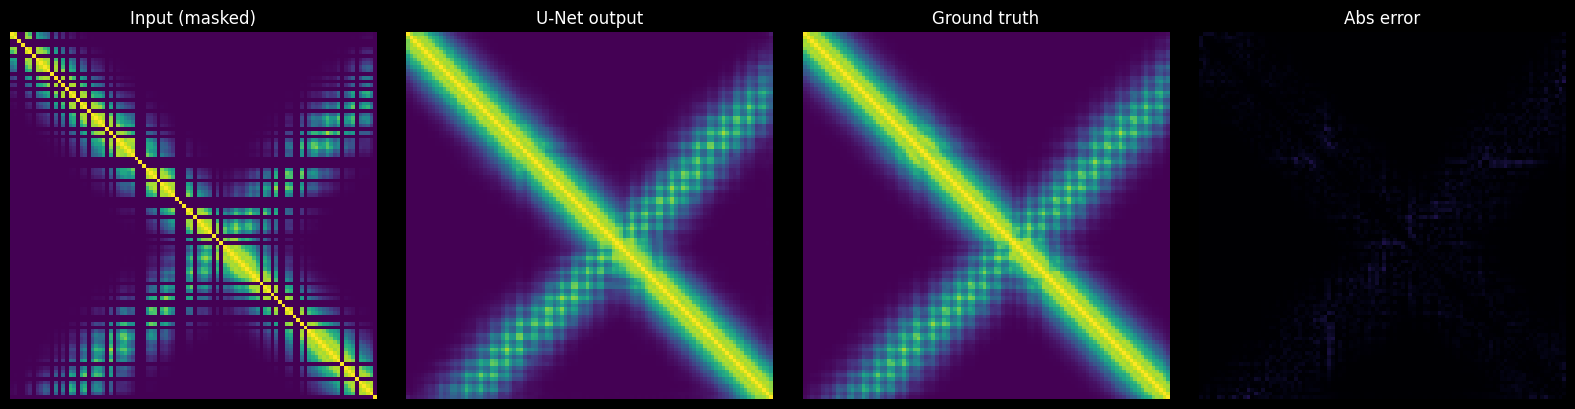

In [11]:
def show_example(mask_fraction: float):
    model = models[mask_fraction]
    model.eval()
    batch = next(iter(test_loader))
    sim_batch, n_used_batch, sample_ids = batch
    masked_sim, missing_mask, valid_mask, target = apply_mask_batch(
        sim_batch,
        n_used_batch,
        mask_fraction,
        generator=None,
        sample_ids=sample_ids,
        deterministic=True,
    )

    inputs = torch.stack(
        [masked_sim, missing_mask.float(), valid_mask.float()], dim=1
    ).to(DEVICE)
    valid_mask = valid_mask.to(DEVICE)
    with torch.no_grad():
        pred = postprocess_pred(model(inputs), valid_mask).cpu()

    i = 0
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(masked_sim[i], vmin=0, vmax=1, cmap="viridis")
    axes[0].set_title("Input (masked)")
    axes[1].imshow(pred[i], vmin=0, vmax=1, cmap="viridis")
    axes[1].set_title("U-Net output")
    axes[2].imshow(target[i], vmin=0, vmax=1, cmap="viridis")
    axes[2].set_title("Ground truth")
    err = (pred[i] - target[i]).abs()
    axes[3].imshow(err, vmin=0, vmax=1, cmap="magma")
    axes[3].set_title("Abs error")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()


show_example(MASK_FRACTIONS[3])


## Block masking (contiguous gaps)

This section replaces random row/column drops with contiguous blocks, which simulate longer missing segments in the index space (i.e., consecutive sequence positions). The same model and metrics are reused to quantify how reconstruction quality degrades as gap size increases.


In [12]:
# Block masking: contiguous rows/cols rather than random rows/cols.

def row_col_block_mask(n_used: int, size: int, mask_fraction: float, generator: torch.Generator | None) -> torch.Tensor:
    missing = torch.zeros((size, size), dtype=torch.bool)
    if n_used <= 1:
        return missing
    k = int(round(mask_fraction * n_used))
    k = max(1, k)
    k = min(k, n_used - 1)
    if k <= 0:
        return missing
    max_start = n_used - k
    start = int(torch.randint(0, max_start + 1, (1,), generator=generator).item())
    idx = torch.arange(start, start + k)
    missing[idx, :n_used] = True
    missing[:n_used, idx] = True
    return missing


def apply_mask_batch_with_fn(
    sim_batch: torch.Tensor,
    n_used_batch: torch.Tensor,
    mask_fraction: float,
    mask_fn,
    generator: torch.Generator | None = None,
    sample_ids: torch.Tensor | None = None,
    deterministic: bool = False,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    b, h, w = sim_batch.shape
    masked_sim = sim_batch.clone()
    missing_mask = torch.zeros_like(sim_batch, dtype=torch.bool)
    valid_mask = torch.zeros_like(sim_batch, dtype=torch.bool)

    for i in range(b):
        n_used = int(n_used_batch[i])
        valid_mask[i, :n_used, :n_used] = True
        if deterministic and sample_ids is not None:
            seed = RANDOM_SEED + int(mask_fraction * 1000) * 100000 + int(sample_ids[i])
            gen = torch.Generator()
            gen.manual_seed(seed)
        else:
            gen = generator
        miss = mask_fn(n_used, h, mask_fraction, gen)
        missing_mask[i] = miss

    diag_mask = torch.eye(h, dtype=torch.bool).unsqueeze(0).expand(b, h, w)
    missing_mask = missing_mask & valid_mask & ~diag_mask

    masked_sim = masked_sim * valid_mask.float()
    masked_sim[missing_mask] = 0.0
    masked_sim[diag_mask & valid_mask] = 1.0

    target = sim_batch * valid_mask.float()
    target[diag_mask & valid_mask] = 1.0

    return masked_sim, missing_mask, valid_mask, target


def train_one_epoch_block(model, loader, optimizer, mask_fraction, device, generator):
    model.train()
    total_mse = 0.0
    total_mae = 0.0
    total_count = 0

    for sim_batch, n_used_batch, _ in loader:
        masked_sim, missing_mask, valid_mask, target = apply_mask_batch_with_fn(
            sim_batch, n_used_batch, mask_fraction, row_col_block_mask, generator=generator
        )
        inputs = torch.stack(
            [masked_sim, missing_mask.float(), valid_mask.float()], dim=1
        ).to(device)
        target = target.to(device)
        missing_mask = missing_mask.to(device)
        valid_mask = valid_mask.to(device)

        optimizer.zero_grad(set_to_none=True)
        pred_raw = model(inputs)
        pred = postprocess_pred(pred_raw, valid_mask)
        loss = masked_mse(pred, target, missing_mask)
        mae = masked_mae(pred, target, missing_mask)
        loss.backward()
        optimizer.step()

        bs = sim_batch.size(0)
        total_mse += loss.item() * bs
        total_mae += mae.item() * bs
        total_count += bs

    return total_mse / max(1, total_count), total_mae / max(1, total_count)


@torch.no_grad()
def eval_model_block(model, loader, mask_fraction, device, deterministic: bool = True):
    model.eval()
    total_mse = 0.0
    total_mae = 0.0
    total_count = 0

    for sim_batch, n_used_batch, sample_ids in loader:
        masked_sim, missing_mask, valid_mask, target = apply_mask_batch_with_fn(
            sim_batch,
            n_used_batch,
            mask_fraction,
            row_col_block_mask,
            generator=None,
            sample_ids=sample_ids,
            deterministic=deterministic,
        )
        inputs = torch.stack(
            [masked_sim, missing_mask.float(), valid_mask.float()], dim=1
        ).to(device)
        target = target.to(device)
        missing_mask = missing_mask.to(device)
        valid_mask = valid_mask.to(device)

        pred_raw = model(inputs)
        pred = postprocess_pred(pred_raw, valid_mask)
        mse = masked_mse(pred, target, missing_mask)
        mae = masked_mae(pred, target, missing_mask)

        bs = sim_batch.size(0)
        total_mse += mse.item() * bs
        total_mae += mae.item() * bs
        total_count += bs

    return total_mse / max(1, total_count), total_mae / max(1, total_count)


@torch.no_grad()
def eval_baselines_block(loader, mask_fraction: float) -> dict:
    totals = {
        "nearest": {"mse": 0.0, "mae": 0.0, "count": 0},
        "linear": {"mse": 0.0, "mae": 0.0, "count": 0},
        "min": {"mse": 0.0, "mae": 0.0, "count": 0},
    }

    for sim_batch, n_used_batch, sample_ids in loader:
        masked_sim, missing_mask, valid_mask, target = apply_mask_batch_with_fn(
            sim_batch,
            n_used_batch,
            mask_fraction,
            row_col_block_mask,
            generator=None,
            sample_ids=sample_ids,
            deterministic=True,
        )

        for i in range(sim_batch.size(0)):
            sim_in = masked_sim[i]
            gt = target[i]
            miss = missing_mask[i]
            valid = valid_mask[i]
            n_used = int(n_used_batch[i])

            pred_nearest = baseline_nearest(sim_in, n_used, miss)
            pred_nearest = postprocess_baseline(pred_nearest, valid)
            pred_linear = baseline_linear(sim_in, n_used, miss)
            pred_linear = postprocess_baseline(pred_linear, valid)
            pred_min = baseline_min(sim_in, n_used, miss, valid)
            pred_min = postprocess_baseline(pred_min, valid)

            for name, pred in [("nearest", pred_nearest), ("linear", pred_linear), ("min", pred_min)]:
                mse = masked_mse(pred, gt, miss).item()
                mae = masked_mae(pred, gt, miss).item()
                totals[name]["mse"] += mse
                totals[name]["mae"] += mae
                totals[name]["count"] += 1

    results = {}
    for name, agg in totals.items():
        count = max(1, agg["count"])
        results[name] = {
            "mse": agg["mse"] / count,
            "mae": agg["mae"] / count,
        }
    return results


def train_for_mask_fraction_block(mask_fraction: float):
    print(f"=== Block mask fraction: {mask_fraction:.2f} ===")
    model = UNet2D().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    gen = torch.Generator().manual_seed(RANDOM_SEED + int(mask_fraction * 1000))

    history = []
    for epoch in range(1, EPOCHS + 1):
        t0 = time.time()
        train_mse, train_mae = train_one_epoch_block(model, train_loader, optimizer, mask_fraction, DEVICE, gen)
        val_mse, val_mae = eval_model_block(model, val_loader, mask_fraction, DEVICE, deterministic=True)
        history.append((train_mse, train_mae, val_mse, val_mae))
        dt = time.time() - t0
        print(
            f"Epoch {epoch:02d}/{EPOCHS} - "
            f"train MSE {train_mse:.6f} MAE {train_mae:.6f} | "
            f"val MSE {val_mse:.6f} MAE {val_mae:.6f} | {dt:.1f}s"
        )

    test_mse, test_mae = eval_model_block(model, test_loader, mask_fraction, DEVICE, deterministic=True)
    print(f"Test MSE {test_mse:.6f} MAE {test_mae:.6f}")
    return model, history, (test_mse, test_mae)


results_block = []
models_block = {}

for frac in MASK_FRACTIONS:
    model, history, (test_mse, test_mae) = train_for_mask_fraction_block(frac)
    models_block[frac] = model
    results_block.append({
        "mask_fraction": frac,
        "method": "unet_block",
        "mse": test_mse,
        "mae": test_mae,
    })

    base_metrics = eval_baselines_block(test_loader, frac)
    for name, metrics in base_metrics.items():
        results_block.append({
            "mask_fraction": frac,
            "method": f"{name}_block",
            "mse": metrics["mse"],
            "mae": metrics["mae"],
        })

print("Block-mask results (lower is better):")
for row in results_block:
    print(row)


=== Block mask fraction: 0.05 ===
Epoch 01/10 - train MSE 0.026634 MAE 0.118029 | val MSE 0.010797 MAE 0.073003 | 4.7s
Epoch 02/10 - train MSE 0.008844 MAE 0.065739 | val MSE 0.008713 MAE 0.068655 | 4.5s
Epoch 03/10 - train MSE 0.007679 MAE 0.060239 | val MSE 0.007992 MAE 0.064124 | 4.6s
Epoch 04/10 - train MSE 0.007097 MAE 0.057352 | val MSE 0.006811 MAE 0.056547 | 4.7s
Epoch 05/10 - train MSE 0.006614 MAE 0.055039 | val MSE 0.006467 MAE 0.054761 | 4.6s
Epoch 06/10 - train MSE 0.005944 MAE 0.052420 | val MSE 0.005554 MAE 0.049755 | 4.8s
Epoch 07/10 - train MSE 0.005531 MAE 0.050307 | val MSE 0.005024 MAE 0.047347 | 4.6s
Epoch 08/10 - train MSE 0.005201 MAE 0.048409 | val MSE 0.005047 MAE 0.049759 | 4.8s
Epoch 09/10 - train MSE 0.004941 MAE 0.046907 | val MSE 0.005261 MAE 0.049222 | 4.7s
Epoch 10/10 - train MSE 0.004901 MAE 0.046298 | val MSE 0.004681 MAE 0.046792 | 4.6s
Test MSE 0.004769 MAE 0.047075
=== Block mask fraction: 0.10 ===
Epoch 01/10 - train MSE 0.040067 MAE 0.152106 | val

### Aggregate plots and relative improvements

Plot MSE/MAE versus mask fraction for both random and block masking, and visualize the percentage improvement of the U-Net over the best baseline. These figures summarize how reconstruction quality changes with gap size and masking regime.


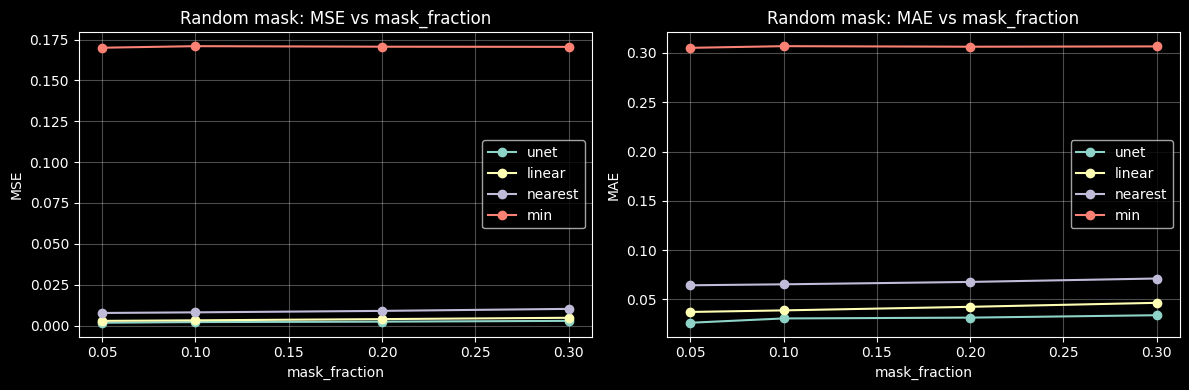

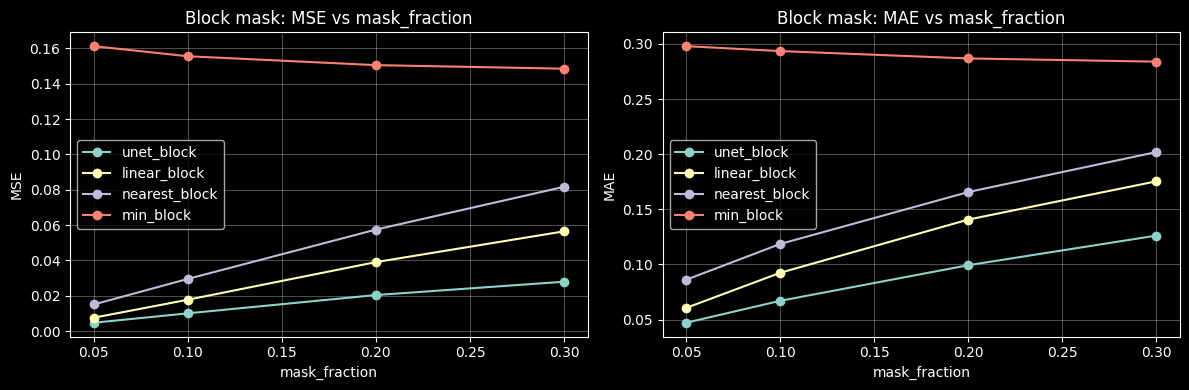

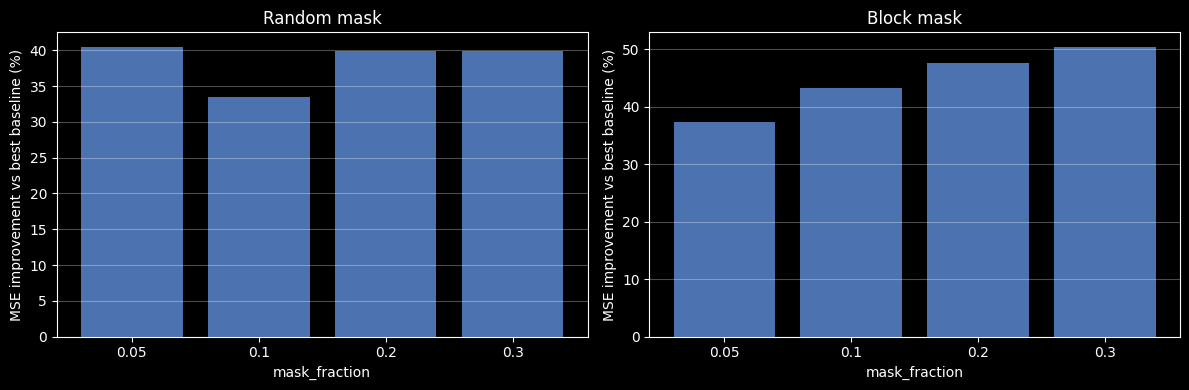

In [14]:

import matplotlib.pyplot as plt


def _build_series(results_list):
    fractions = sorted({row["mask_fraction"] for row in results_list})
    series = {}
    for row in results_list:
        method = row["method"]
        series.setdefault(method, {"mask_fraction": [], "mse": [], "mae": []})
        series[method]["mask_fraction"].append(row["mask_fraction"])
        series[method]["mse"].append(row["mse"])
        series[method]["mae"].append(row["mae"])
    # sort per method by mask_fraction
    for method, vals in series.items():
        order = sorted(range(len(vals["mask_fraction"])), key=lambda i: vals["mask_fraction"][i])
        for k in ["mask_fraction", "mse", "mae"]:
            vals[k] = [vals[k][i] for i in order]
    return fractions, series


def _plot_lines(series, metric, ax, title, order=None):
    methods = order if order is not None else sorted(series.keys())
    for method in methods:
        if method not in series:
            continue
        ax.plot(
            series[method]["mask_fraction"],
            series[method][metric],
            marker="o",
            label=method,
        )
    ax.set_xlabel("mask_fraction")
    ax.set_ylabel(metric.upper())
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend()


def _plot_improvement(results_list, unet_key, baseline_keys, ax, title):
    fractions = sorted({row["mask_fraction"] for row in results_list})
    improvements = []
    labels = []
    for frac in fractions:
        unet_vals = [r["mse"] for r in results_list if r["mask_fraction"] == frac and r["method"] == unet_key]
        baseline_vals = [r["mse"] for r in results_list if r["mask_fraction"] == frac and r["method"] in baseline_keys]
        if not unet_vals or not baseline_vals:
            continue
        best_baseline = min(baseline_vals)
        improvement = (best_baseline - unet_vals[0]) / max(1e-12, best_baseline) * 100.0
        improvements.append(improvement)
        labels.append(str(frac))
    ax.bar(labels, improvements, color="#4c72b0")
    ax.set_xlabel("mask_fraction")
    ax.set_ylabel("MSE improvement vs best baseline (%)")
    ax.set_title(title)
    ax.axhline(0, color="black", linewidth=0.8)
    ax.grid(True, axis="y", alpha=0.3)


def _plot_results_grid(results_list, label, order):
    _, series = _build_series(results_list)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    _plot_lines(series, "mse", axes[0], f"{label}: MSE vs mask_fraction", order)
    _plot_lines(series, "mae", axes[1], f"{label}: MAE vs mask_fraction", order)
    plt.tight_layout()
    plt.show()


_plot_results_grid(results, "Random mask", ["unet", "linear", "nearest", "min"])

_plot_results_grid(results_block, "Block mask", ["unet_block", "linear_block", "nearest_block", "min_block"])

# Improvement over best baseline (MSE)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
_plot_improvement(results, "unet", {"linear", "nearest", "min"}, axes[0], "Random mask")
_plot_improvement(results_block, "unet_block", {"linear_block", "nearest_block", "min_block"}, axes[1], "Block mask")
plt.tight_layout()
plt.show()


### Scratch cell (optional)

This cell is intentionally left empty for optional, ad hoc analyses or additional plots. Keeping it blank avoids altering the computational results above.


## Results, conclusions, and future directions

Results summary (test metrics on masked entries only):
- Random row/column masking: U-Net MSE/MAE = 0.001688/0.02637 (5%), 0.002108/0.03074 (10%), 0.002355/0.03156 (20%), 0.002844/0.03401 (30%). The best baseline is linear interpolation with MSE 0.002836, 0.003169, 0.003917, 0.004730 at the same fractions, so the learned model improves consistently.
- Block masking (contiguous gaps): U-Net MSE/MAE = 0.004769/0.04708 (5%), 0.01010/0.06697 (10%), 0.02044/0.09927 (20%), 0.02798/0.12613 (30%). The best baseline remains linear interpolation with MSE 0.007614, 0.01778, 0.03908, 0.05649, so the U-Net retains a clear margin even for larger blocks.

Conclusions:
- For random masking, reconstruction error grows slowly from 5% to 30% removed rows/columns, indicating that the model captures context beyond simple interpolation.
- For contiguous blocks, error rises much faster, which is expected because long gaps remove local context; performance is still better than baselines but degrades notably past 20%.
- Answer to the question: in this setup, gaps of about 20% of rows/columns are effectively fillable for contiguous blocks, while random missing rows/columns remain effectively reconstructable up to at least 30% given the observed MSE/MAE levels.

Possible future directions:
- Increase model capacity or add attention to improve long-range propagation for large contiguous gaps.
- Train with a mixture of random and block masks and a wider range of fractions to improve robustness.
- Evaluate alternative similarity definitions or downstream tasks to validate whether improvements translate to practical utility.
- Add uncertainty estimates to flag low-confidence reconstructions.
